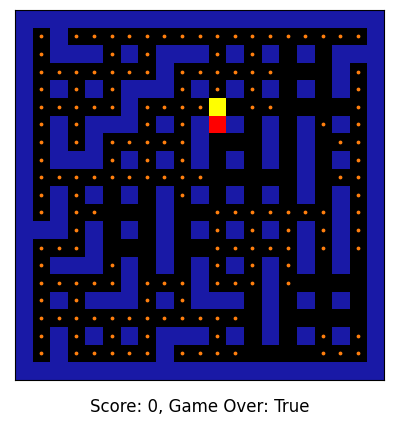

In [1]:
import random
import numpy as np
from IPython import display
from matplotlib import colors
import matplotlib.pyplot as plt

class PacManEnv:
    def __init__(self):
        
#         self.grid = np.array([
#             ["W", "W", "W", "W", "W", "W", "W", "W", "W", "W", "W", "W"],
#             ["W", ".", ".", ".", ".", "W", ".", ".", ".", ".", ".", "W"],
#             ["W", ".", "W", ".", "W", "W", ".", "W", ".", "W", "W", "."],
#             ["W", "P", "W", ".", ".", ".", ".", "W", ".", ".", ".", "W"],
#             ["W", ".", "W", "W", "W", "W", ".", "W", "W", ".", "W", "W"],
#             ["W", ".", ".", ".", ".", ".", ".", ".", ".", ".", ".", "W"],
#             ["W", ".", "W", "W", ".", "W", "W", ".", "W", ".", "W", "W"],
#             ["W", ".", ".", ".", ".", "W", ".", ".", ".", ".", ".", "W"],
#             ["W", "W", "W", "W", "W", "W", "W", "W", "W", "W", "W", "W"]
#         ], dtype='<U1')
        self.grid_shape = [21, 21]
        self.num_ghosts = 1
        self.generate_random_maze()
        self.ghost_pos_value = ["." for _ in range(self.num_ghosts)]
        self.place_characters()
        self.remove_pellet_chunks()
        self.mapping = {'W': 1, ' ': 0, 'P': 3, 'G': 4, '.': 5}
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        
#         self.pacman_position = (3, 1)        
        
        # Place additional ghosts on the grid
#         self.ghost_positions = [(7, 5), (1, 10), (6, 1), (6, 10)]
#         self.ghost_positions = []
#         for pos in self.ghost_positions:
#             self.grid[pos] = 'G'
        self.score = 0
        self.done = False
        
#     def generate_random_maze(self):
#         self.grid = np.full(self.grid_shape, '.', dtype='<U1')
#         self.grid[0, :] = self.grid[-1, :] = 'W'
#         self.grid[:, 0] = self.grid[:, -1] = 'W'
#         for _ in range(int(np.product(self.grid_shape) * 0.2)):
#             x, y = np.random.randint(1, self.grid_shape[0]-1), np.random.randint(1, self.grid_shape[1]-1)
#             self.grid[x, y] = 'W'

    def generate_random_maze(self):
        # Initialize all cells as walls
        self.grid = np.full(self.grid_shape, 'W', dtype='<U1')

        # Start with a random cell, mark it as passage
        start_x, start_y = (np.random.randint(2, self.grid_shape[0] - 2, size=2) | 1)
        self.grid[start_x, start_y] = '.'

        # Keep track of the "frontier" cells: cells that are walls but are adjacent to empty spaces
        frontier = [(start_x, start_y + 2), (start_x, start_y - 2), (start_x + 2, start_y), (start_x - 2, start_y)]

        while frontier:
            # Choose a random frontier cell
            fx, fy = random.choice(frontier)
            if not ((0 <= fx < self.grid_shape[0]) and (0 <= fy < self.grid_shape[1])):
                frontier.remove((fx, fy))
                continue

            # Identify the neighbors of this cell (in the maze, not the frontier)
            neighbors = [(fx + 2, fy), (fx - 2, fy), (fx, fy + 2), (fx, fy - 2)]
            neighbors = [(nx, ny) for nx, ny in neighbors if (0 <= nx < self.grid_shape[0]) and (0 <= ny < self.grid_shape[1]) if self.grid[nx][ny] == '.']

            if neighbors:
                # Choose a random neighbor and remove the wall between the frontier cell and the neighbor
                nx, ny = random.choice(neighbors)
                self.grid[(fx + nx) // 2][(fy + ny) // 2] = '.'
                self.grid[fx][fy] = '.'

                # Add the new neighbors to the frontier
                new_frontiers = [(fx + 2, fy), (fx - 2, fy), (fx, fy + 2), (fx, fy - 2)]
                new_frontiers = [(nx, ny) for nx, ny in new_frontiers if 0 < nx < self.grid_shape[0]-1 and 0 < ny < self.grid_shape[1]-1 and self.grid[nx][ny] == 'W']
                frontier.extend(new_frontiers)

            # Remove the processed cell from the frontier
            frontier.remove((fx, fy))

        # Ensure the perimeter is all walls
        self.grid[0, :] = self.grid[-1, :] = 'W'
        self.grid[:, 0] = self.grid[:, -1] = 'W'


    def remove_pellet_chunks(self, chunk_count=8, chunk_size=4):
        """
        Randomly removes chunks of pellets from the maze.

        Parameters:
        - chunk_count: The number of chunks to remove.
        - chunk_size: The size of each chunk (number of cells in each direction from the start point).
        """
        for _ in range(chunk_count):
            # Randomly select a start point for the chunk
            start_x = np.random.randint(1, self.grid_shape[0] - chunk_size)
            start_y = np.random.randint(1, self.grid_shape[1] - chunk_size)

            # Determine the bounds of the chunk
            end_x = min(start_x + chunk_size, self.grid_shape[0] - 1)
            end_y = min(start_y + chunk_size, self.grid_shape[1] - 1)

            # Clear the pellets within the chunk
            for x in range(start_x, end_x):
                for y in range(start_y, end_y):
                    if self.grid[x, y] == '.':  # Check if there's a pellet
                        self.grid[x, y] = ' '  # Clear the pellet
        
            
    def place_characters(self):
        self.pacman_position = self.random_empty_position()
        self.grid[self.pacman_position] = 'P'
        self.ghost_positions = [self.random_empty_position() for _ in range(self.num_ghosts)]
        for pos in self.ghost_positions:
            self.grid[pos] = 'G'

    def random_empty_position(self):
        while True:
            position = (np.random.randint(1, self.grid_shape[0]-1), np.random.randint(1, self.grid_shape[1]-1))
            if self.grid[position] == '.':
                return position

    def reset(self):
        return self.encode(self.grid.copy())

    def step(self, action):
        reward = 0
        if self.done:
            return self.grid.copy(), reward, True, {}

        # Move Pac-Man
        reward, pacman_done = self.move_pacman(action)
        
        # Move Ghosts
        ghosts_done = self.move_ghosts()
        
        self.done = pacman_done or ghosts_done
        return self.encode(self.grid.copy()), reward, self.done, {}

    def move_pacman(self, action):
#         directions = {'left': (0, -1), 'right': (0, 1), 'up': (-1, 0), 'down': (1, 0)}
#         move = directions[action]
        idx = np.argmax(action)
        move = self.actions[idx]
        
        next_position = (self.pacman_position[0] + move[0], self.pacman_position[1] + move[1])
        if self.grid[next_position] != 'W' and self.grid[next_position] != 'G':
            if self.grid[next_position] == '.':
                self.score = 10
            else:
                self.score = 0
            self.grid[self.pacman_position] = ' '
            self.pacman_position = next_position
            self.grid[self.pacman_position] = 'P'
            return self.score, False
        elif self.grid[next_position] == 'G':
            return 0, True  # Pac-Man caught by a ghost
        return 0, False

    def move_ghosts(self):
        for i, pos in enumerate(self.ghost_positions):
            direction = self.choose_ghost_direction(pos)
            next_position = (pos[0] + direction[0], pos[1] + direction[1])
            if self.grid[next_position] != 'W' and self.grid[next_position] != 'P':
                self.grid[pos] = self.ghost_pos_value[i]
                self.ghost_positions[i] = next_position
                self.ghost_pos_value[i] = self.grid[next_position]
                self.grid[next_position] = 'G'
            elif self.grid[next_position] == 'P':
                return True  # Ghost catches Pac-Man
        return False

    def choose_ghost_direction(self, ghost_position):
        # Simple AI to move the ghost towards Pac-Man
        possible_moves = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # left, right, up, down
        if np.random.rand() <= 0.5:
            directions = []
            for move in possible_moves:
                new_position = (ghost_position[0] + move[0], ghost_position[1] + move[1])
                if self.grid[new_position] != 'W':
                    directions.append(move)
            # Choose the move that minimizes the distance to Pac-Man, if multiple, choose randomly
            if directions:
                return min(directions, key=lambda x: np.linalg.norm(np.array(self.pacman_position) - np.array((ghost_position[0] + x[0], ghost_position[1] + x[1]))))
        return random.choice(possible_moves)  # Fallback to a random move if no direct path

    def render(self, ax=None) -> None:
        
        plt.cla()
        if ax is None:
            fig, ax = plt.subplots()
        
        # Adjusted to color walls dark blue
        color_map = colors.ListedColormap(['black', '#1919A6', 'white', '#FFFF00', 'red', 'gray'])
        norm = colors.BoundaryNorm([0, 1, 2, 3, 4, 5, 6], color_map.N)

        grid_render = np.zeros(self.grid.shape, dtype=int)
#         for char, value in mapping.items():
#             grid_render[self.grid == char] = value

        for char, value in self.mapping.items():
            if char == '.':  # Pellets
                y, x = np.where(self.grid == char)
                ax.scatter(x, y, c='#ff7f0e', marker='o', s=3)  # Plot pellets as green dots
            else:
                grid_render[self.grid == char] = value

        ax.imshow(grid_render, cmap=color_map, norm=norm)
        plt.xticks([]), plt.yticks([])
        action_text = f"Score: {self.score}, Game Over: {self.done}"
        plt.text(0.5, -0.05, action_text, ha='center', va='top', color='black', fontsize=12, transform=ax.transAxes)
        
    def encode(self, obs) -> np.array:
        return np.array(list(map(lambda x: self.mapping[x] - 3, obs.flatten())))

env = PacManEnv()
env.reset()
fig, ax = plt.subplots()

while True:
    action = np.zeros(4)
    action[np.random.randint(0, 4)] = 1
    obs, score, done, _ = env.step(action)
    env.render(ax)
    
    if done:
        break
        
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [2]:
!pip install neat-python

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
"""
Single-pole balancing experiment using a feed-forward neural network.
"""

import multiprocessing
import os
import pickle
import neat

runs_per_net = 2
simulation_seconds = 120.0


# Use the NN network phenotype and the discrete actuator force function.
def eval_genome(genome, config):
    net = neat.nn.FeedForwardNetwork.create(genome, config)

    fitnesses = []

    for runs in range(runs_per_net):
        env = PacManEnv()
        obs = env.reset()

        # Run the given simulation for up to num_steps time steps.
        fitness = 0.0
        done = False
        while not done:
            
            action = net.activate(obs)
            obs, score, done, info = env.step(action)
            
            fitness += score

        fitnesses.append(fitness)

    # The genome's fitness is its worst performance across all runs.
    return min(fitnesses)


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = eval_genome(genome, config)


def run():
    # Load the config file, which is assumed to live in
    # the same directory as this script.
    local_dir = os.path.dirname("./")
    config_path = os.path.join(local_dir, 'config-feedforward')
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_path)

    pop = neat.Population(config)
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)
    pop.add_reporter(neat.StdOutReporter(True))

    pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
    winner = pop.run(pe.evaluate)

    # Save the winner.
    with open('winner-feedforward', 'wb') as f:
        pickle.dump(winner, f)

    print(winner)


run()


 ****** Running generation 0 ****** 

Population's average fitness: 7.40000 stdev: 14.94122
Best fitness: 60.00000 - size: (5, 1104) - species 1 - id 27

Best individual in generation 0 meets fitness threshold - complexity: (5, 1104)
Key: 27
Fitness: 60.0
Nodes:
	0 DefaultNodeGene(key=0, bias=1.176465615262513, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.7272332421040875, response=1.0, activation=sigmoid, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-0.2973145064247674, response=1.0, activation=sigmoid, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=1.0282830783184158, response=1.0, activation=sigmoid, aggregation=sum)
	30 DefaultNodeGene(key=30, bias=-1.1679977121940759, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-441, 0), weight=-2.4154232800811535, enabled=True)
	DefaultConnectionGene(key=(-441, 1), weight=-1.2370701897650356, enabled=True)
	DefaultConnectionGene(key=(-441, 3), weight=-0.4